# OCR Text Recognition

https://www.kaggle.com/code/meetnagadia/extract-text-from-images/notebook

An **OCR Program** is a tool that **extracts and re-purposes data from scanned documents, camera images, and image-only pdf**. An OCR system uses a combination of hardware, such as optical scanners and software capable of image processing."

For text extraction, the OCR tools (OCR libraries) employ several machine algorithms for pattern recognition to identify the presence and layout of the text in an image file.

The primary benefit of OCR technology is that **it automates manual and time-consuming data entry tasks**. This is because by using OCR, we can create digital documents that can be edited and stored per requirements. Automated, faster processing and conversion of paper-based documents into digital formats that accelerate workflows:

- It saves time and reduces the scope of manual errors;

- Eliminates the requirement for manual data entry;

- Reduced manual data entry indicates reduced overall costs for the business;

- It saves paper and storage space as more data can be converted to electronic format.

https://it.wikipedia.org/wiki/Riconoscimento_ottico_dei_caratteri

For this task, we are going to exploit **Keras library**: a powerful open-source library. The Keras-OCR library provides a high-level API and end-to-end training pipeline to build new OCR models.

In [23]:
import keras_ocr
from keras import optimizers
from tensorflow import keras
import matplotlib.pyplot as plt

We set up a pipeline: the download model will be a pre-trained text extraction model loaded with pre-trained weights for the detector and recognizer.

In [3]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/pierluigi/.keras-ocr/craft_mlt_25k.h5


2024-10-31 15:14:53.766476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-31 15:14:53.767949: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-10-31 15:14:56.632997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gra

Looking for /home/pierluigi/.keras-ocr/crnn_kurapan.h5


Let's take two images as example:

In [11]:
images = [
    keras_ocr.tools.read(img) for img in ['/home/pierluigi/Documents/datasets/Text Extraction/1.jpg',
                                          '/home/pierluigi/Documents/datasets/Text Extraction/103.jpg',
                                          '/home/pierluigi/Documents/datasets/Text Extraction/test.png']
]

We'll use two images to test the capabilities of the Keras-ocr library, running the pipeline recognize and make predictions about the text in these images.

In [12]:
# generate text predictions from the images
prediction_groups = pipeline.recognize(images)

2/2 [==============================] - 4s 661ms/step


### Plotting the predictions

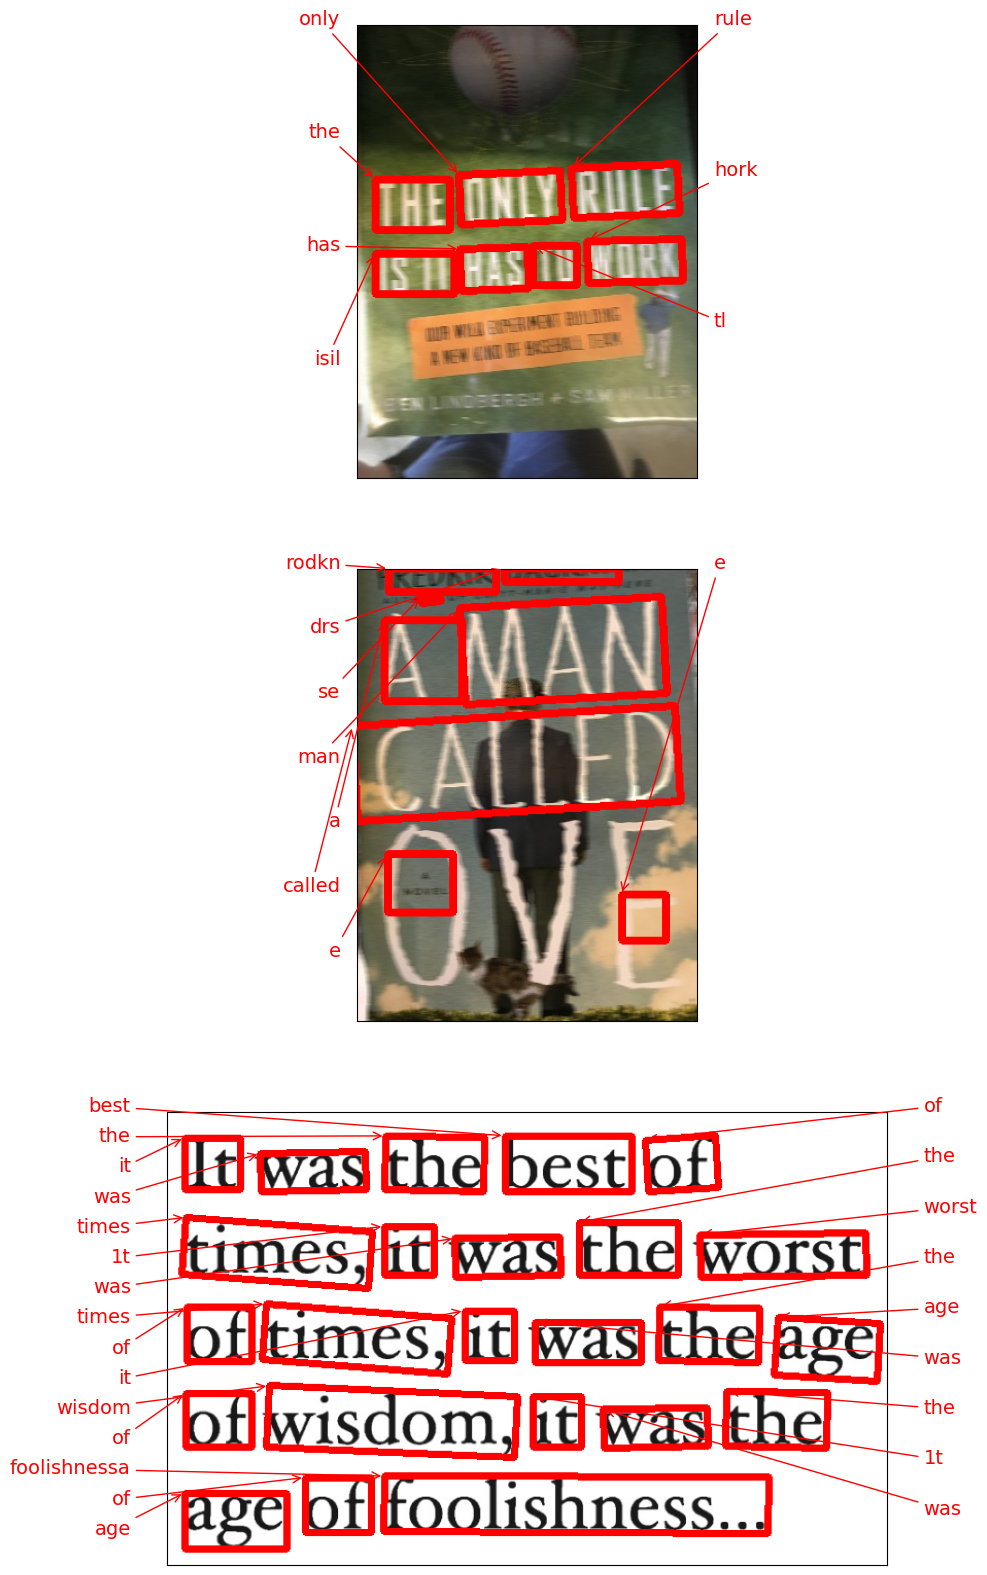

In [13]:
# plot the text predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(10, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)

In [14]:
predicted_image = prediction_groups[0]
for text, box in predicted_image:
    print(text)

rule
only
the
hork
tl
has
isil


In [15]:
predicted_image = prediction_groups[1]
for text, box in predicted_image:
    print(text)

rodkn
drs
se
man
a
called
e
e


In [16]:
predicted_image = prediction_groups[2]
for text, box in predicted_image:
    print(text)

best
the
of
it
was
the
times
1t
worst
was
of
the
times
it
age
was
wisdom
the
of
1t
was
foolishnessa
of
age


### Save the model

In [18]:
# Salva la pipeline in un file
pipeline.recognizer.model.save('text_recognition_model.h5')

In [26]:
# Carica il modello di riconoscimento del testo
pipeline.recognizer.model = keras.models.load_model('/home/pierluigi/Documents/models/Text Recognition/text_recognition_model.h5')

2024-10-31 16:22:27.836144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-31 16:22:27.837856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-31 16:22:27.838918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [28]:
# Compila il modello (inserisci qui la tua loss function e le metriche)
pipeline.recognizer.model.compile(optimizer=keras.optimizers.Adam(),
                                   loss='categorical_crossentropy',  # o la loss function che hai usato
                                   metrics=['accuracy'])  # o le metriche che desideri

# Ora puoi usare la pipeline per fare previsioni
images = [
    keras_ocr.tools.read(img) for img in ['/home/pierluigi/Documents/datasets/Text Extraction/1.jpg',
                                          '/home/pierluigi/Documents/datasets/Text Extraction/103.jpg',
                                          '/home/pierluigi/Documents/datasets/Text Extraction/test.png']
]
prediction_groups = pipeline.recognize(images)

2/2 [==============================] - 4s 822ms/step


In [30]:
# Salva la pipeline in un file
pipeline.recognizer.model.save('text_recognition_model.h5')